In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install tensorflow_ranking

In [3]:
from keras.layers import Embedding, Input, dot, concatenate
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import adam_v2
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import numpy as np # linear algebra
import pandas as pd
from tensorflow import keras
# import tensorflow_ranking as tfr

Loading the dataset

In [4]:
df_rec = pd.read_csv("drive/MyDrive/RAW_recipes.csv")
df_rec.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [5]:
df = pd.read_csv("drive/MyDrive/RAW_interactions.csv")
df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


Preparing for Matrix Factorization

In [6]:
user_id_dict = {}
k=0
for i in df['user_id']:
  if i not in user_id_dict:
    user_id_dict[i] = k
    k+=1

recipe_id_dict = {}
k=0
for i in df['recipe_id']:
  if i not in recipe_id_dict:
    recipe_id_dict[i] = k
    k+=1

In [7]:
df['user_id_ordered']= df['user_id'].map(user_id_dict)
df

,user_id,recipe_id,date,rating,review,user_id_ordered
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,0
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",1
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,3
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",4
...,...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,226568
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...,178207
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...,30308
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...,123


In [8]:
df['recipe_id_ordered']= df['recipe_id'].map(recipe_id_dict)
df

,user_id,recipe_id,date,rating,review,user_id_ordered,recipe_id_ordered
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,0,0
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",1,0
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,2,1
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,3,2
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",4,2
...,...,...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,226568,231635
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...,178207,231636
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...,30308,231618
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...,123,231618


In [9]:
df_new = df[['user_id_ordered','recipe_id_ordered','rating']]

In [10]:
df_new = df_new.rename(columns={'user_id_ordered':'userId','recipe_id_ordered':'recipeId'})

In [11]:
df_new = df_new.iloc[:100000, :]

In [12]:
df_new.head()

,userId,recipeId,rating
0,0,0,4
1,1,0,5
2,2,1,4
3,3,2,5
4,4,2,5


In [13]:
X = df_new.iloc[:,:2]
Y = df_new.iloc[:,2]

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

Preprocessing the dataset for BERT

In [15]:
n_recipes = sorted(df_rec['id'].unique())

In [16]:
df_rec.rename(columns = {'id':'recipeId'}, inplace = True)

In [17]:
joined = df_rec.merge(X,on="recipeId",how="right")

In [18]:
joined = joined.drop('userId', axis=1)

In [19]:
joined.drop_duplicates(inplace=True)

In [20]:
len(joined)

19555

In [21]:
(joined['recipeId'].unique())

array([    0,     1,     2, ..., 19552, 19553, 19554])

In [22]:
joined.fillna(0)
joined.reset_index(inplace=True,drop=True)
joined = joined.applymap(str)

Laoding the pre-trained sentence tokenizer BERT model ( We used this on description of recipes, as they represent the recipe and Sentence encoder take a paragraph as input)

In [23]:
!pip install sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
from sentence_transformers import SentenceTransformer
model_bert = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

Creating embeddings for Recipes


In [26]:
joined["Embeddings"] = joined['description'].apply(lambda x: model_bert.encode(x))

In [27]:
joined['Embeddings'].shape

(19555,)

Creating the embedding matrix to feed it to the network

In [28]:
embeddings_matrix = np.empty((len(joined), 768))
for i in range(len(joined['Embeddings'])):
  embeddings_matrix[i] = joined['Embeddings'].loc[i]

In [29]:
embeddings_matrix.shape

(19555, 768)

In [30]:
n_latent_factors = 768

n_users, n_recipes = len(df_new['userId'].unique()), len(df_new['recipeId'].unique()) 

Intializing the model

In [31]:
from keras.initializers import Constant
# recipe_embedding_matrix = np.random.random((n_recipes, n_latent_factors))
recipe_embedding_matrix = embeddings_matrix
user_input = Input(shape=(1,), name='User_Input',dtype='int32')
user_embeddings = Embedding(input_dim = n_users, output_dim=n_latent_factors, input_length=1, 
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


recipe_input = Input(shape=(1,), name='Recipe_Input',dtype='int32')
recipe_embeddings = Embedding(input_dim = n_recipes, output_dim=n_latent_factors, input_length=1, 
                               name='Recipe_Embedding',trainable=True,embeddings_initializer=Constant(recipe_embedding_matrix)) (recipe_input)
recipe_vector = Flatten(name='Recipe_Vector') (recipe_embeddings)

print(user_vector.shape)
print(recipe_vector.shape)

# Concatenate Product
merged_vectors = concatenate([user_vector, recipe_vector], name='Concantenate')

print(merged_vectors.shape)
dense_layer_1 = Dense(100, activation='relu')(merged_vectors) 
dense_layer_1 = Dropout(0.25) (dense_layer_1)
batchnorm_layer_1 = BatchNormalization()(dense_layer_1)
dense_layer_2 = Dense(64, activation='relu')(merged_vectors)


result = Dense(1)(dense_layer_1)
model = Model([user_input, recipe_input], result)

(None, 768)
(None, 768)
(None, 1536)


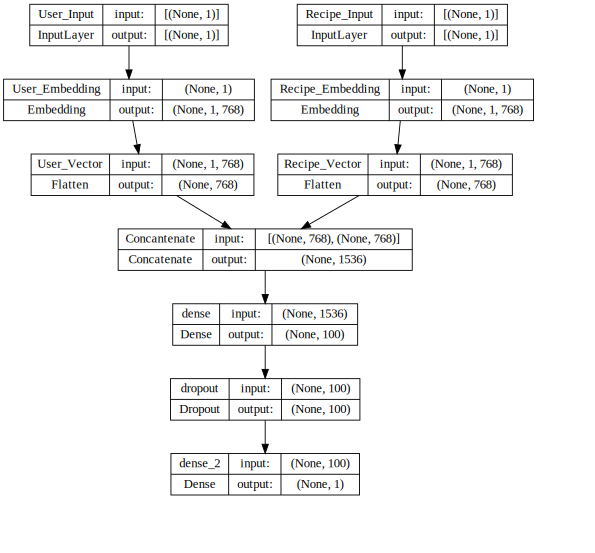

In [32]:
SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User_Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Recipe_Input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 User_Embedding (Embedding)     (None, 1, 768)       29379840    ['User_Input[0][0]']             
                                                                                                  
 Recipe_Embedding (Embedding)   (None, 1, 768)       15018240    ['Recipe_Input[0][0]']           
                                                                                              

In [34]:
# !pip install tensorflow_ranking

Intializing the metrics - NDCG and MRR and loss function - MAE to train the model

In [35]:
import tensorflow_ranking as tfr
from keras.metrics import top_k_categorical_accuracy,MeanAbsoluteError
eval_metrics = [
    tfr.keras.metrics.get(key="ndcg", name="metric/ndcg", ragged=False),
    tfr.keras.metrics.get(key="mrr", name="metric/mrr", ragged=False)
]
optimizer = adam_v2.Adam(learning_rate = 0.005)

model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=[keras.metrics.MeanAbsoluteError(),'top_k_categorical_accuracy',eval_metrics])

In [36]:
batch_size = 128
epochs = 10

In [37]:
y_test.head()

20818    5
51366    5
61821    5
38292    5
36183    5
Name: rating, dtype: int64

Training the model

In [38]:
history = model.fit(x=[x_train['userId'], x_train['recipeId']], y=y_train, batch_size= batch_size, epochs=epochs, 
                    verbose= 2,validation_data=([x_test['userId'], x_test['recipeId']], y_test))

Epoch 1/10
625/625 - 21s - loss: 2.0058 - mean_absolute_error: 1.0039 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.9486 - metric/mrr: 0.9486 - val_loss: 1.6069 - val_mean_absolute_error: 0.8536 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.9466 - val_metric/mrr: 0.9466 - 21s/epoch - 34ms/step
Epoch 2/10
625/625 - 18s - loss: 1.3064 - mean_absolute_error: 0.8192 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.9486 - metric/mrr: 0.9486 - val_loss: 1.6433 - val_mean_absolute_error: 0.8993 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.9466 - val_metric/mrr: 0.9466 - 18s/epoch - 28ms/step
Epoch 3/10
625/625 - 18s - loss: 0.7771 - mean_absolute_error: 0.6269 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.9486 - metric/mrr: 0.9486 - val_loss: 1.6609 - val_mean_absolute_error: 0.9309 - val_top_k_categorical_accuracy: 1.0000 - val_metric/ndcg: 0.9466 - val_metric/mrr: 0.9466 - 18s/epoch - 28ms/step
Epoch 4/10
625/625 - 18s - loss: 0.6128 - m

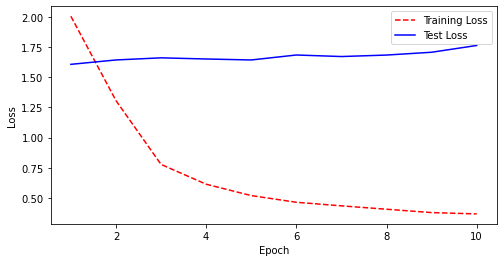

In [39]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [40]:
score = model.evaluate([x_test['userId'], x_test['recipeId']], y_test)
score
# print()
# print('RMSE: {:.4f}'.format(np.sqrt(score)))

625/625 [==============================] - 4s 7ms/step - loss: 1.7633 - mean_absolute_error: 0.8252 - top_k_categorical_accuracy: 1.0000 - metric/ndcg: 0.9466 - metric/mrr: 0.9466


[1.763315200805664,
 0.8252237439155579,
 1.0,
 0.9465500116348267,
 0.9465500116348267]

Extracting the newly generated embeddings

In [41]:
embedding_layer = model.get_layer(name="Recipe_Embedding")
embeddings_new = embedding_layer.get_weights()

In [42]:
len(embeddings_new[0])

19555

In [43]:
len(recipe_embedding_matrix[0])

768

Training the KNN model on old embeddings

In [45]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=10)
knn.fit(recipe_embedding_matrix) #embedding vectors
# # select indices of k nearest neighbours
# neighbours = knn.kneighbors([x], return_distance = False)
# print(neighbours)

NearestNeighbors(n_neighbors=10)

In [49]:
from sklearn.metrics import ndcg_score

Evaluating the results - NDCG, MRR and Top_K

In [ ]:
mrr = 0
top_k = 0
ndcg = 0
for i in range(len(recipe_embedding_matrix)):
  neighbours = knn.kneighbors([embeddings_new[0][i]], return_distance = False)
  neighbours_old = knn.kneighbors([recipe_embedding_matrix[i]], return_distance = False)
  ndcg += ndcg_score(neighbours_old,neighbours)
  count = 0
  for i in range(len(neighbours[0])):
    if neighbours[0][i] in neighbours_old[0:4] and i!=neighbours[0][i]:
      count+=1
    if neighbours[0][i] in neighbours_old[0] and i!=neighbours[0][i]:
      mrr+=1/(i+1)
      break
  # print(top_k)
  top_k +=count
print("NDCG:",ndcg/len(recipe_embedding_matrix))
print("Top_K:",top_k/len(recipe_embedding_matrix))
print("MRR:",mrr/len(recipe_embedding_matrix))
# NDCG: 0.9385415408564605
# Top_K: 0.669677831756584
# MRR: 0.648334205923037